## Modeling non-linear functions with linear approxmations

In [1]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

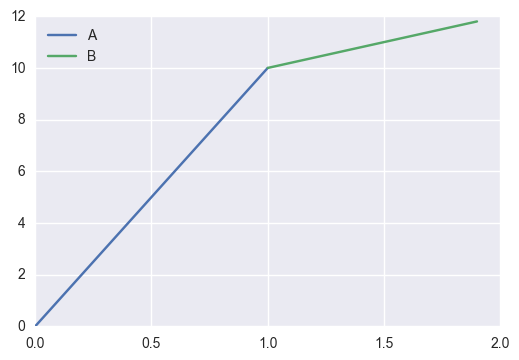

In [2]:
x1 = np.arange(0,1+.1,.1)
y1 = 10*x1
x2 = np.arange(1,2,.1)
y2 = 2*x2 + 8

plt.plot(x1,y1, label='A')
plt.plot(x2,y2, label='B')
plt.legend(loc='best')

### model a piecewise function

Lets say we have a piecewise defined function defined as follows:

$$f(x) = \begin{cases} 
10x \text{ if } 0 \leq x \leq 1 \\
2x + 8 \text{ if } 0 \leq x \leq 1
\end{cases}$$
where $0 \leq x \leq 2\\$

We can create two binary variables $b_{1}$ and $b_{2}$ which will track which segment of the piecewise function we are currently in. We also need to create two new continuous variables $x_{1}$ and $x_{2}$ to serve as the $x$ variable inside each segment. i.e.,

$$x_{i} = \begin{cases} 0 \text{ if } x_{i} \text{ in interval } i \\ 0 \text{ otherwise} \end{cases} $$

$f$ becomes:

$$f(x) = 10x_{1}  - 2x_{2} + 8b_{2}$$
subject to:
$$
0*b_{1} \leq x_{1} \leq 1b_{1} \\
1b_{2} \leq x_{1} \leq 2b_{2} \\
b_{1} + b_{2} = 1 \\ 
x = x_{1}+x_{2}$$

If we can model a piecewise function, we can approximate a ton of curvy functions at the cost of lots of new binary and continuous variables.

### Fixed costs

The simplest application of the above that is very immediately useful is in modeling fixed costs. 

Lets revisit factory routing problem from earlier. Recall that we were trying to select lanes to minimize the lane costs. Our data had the cost per unit shipped for each lane. 

$$f(Lanes) = \sum_{o,d \in Lanes} qty_{o,d}*cost_{o,d} $$

We can make the lane cost model a little close to reality. In reality the costs should probably decrease per unit shipped due to efficiencies in scaling, and shipping only a few units should be fairly expensive as we might still have to pay for a truck driver etc.

The cost of one lane:

$cost(x) = \text{initial_cost} + \text{cost_per_unit}*x$

The problem is we can't just sum the cost of every lane because that initial cost should only be counted when that lane is selected. We can use a binary variable $b_{o,d}$ to model if we select lane $o,d$

$cost(x) = \text{initial_cost}b + \text{cost_per_unit}*x$

but we need to make sure that if we don't select this lane, then the $x$ is 0. If we place a reasonable bound on $x$ then we can write:
$x \leq b*M$.

Our new modifications:

new variables:
$$b_{o,d} = \begin{cases} 1 \text{ if lane o,d is selected} \\
0 \text{otherwise}
\end{cases} \: \forall o,b \in \: Lanes$$

new constraints
$$qty_{o,d} \leq b_{o,d}M \: \forall o,b \in \: Lanes$$

and the cost function
$$f(Lanes) = \sum_{o,d \in Lanes} \text{initial_cost}_{o,d}b_{o,d} + qty_{o,d}*cost_{o,d} $$

We still need to decide what M should be. In this example, M should really be the maximum amount of goods a single truck can carry. But then we would be limiting the solution to only ever using one truck per lane. Instead, we can set M to be the maximum amount a truck can carry and modify $b$!. Instead of being a binary variable to turn on and off the lane, we can make $b$ count the number of trucks we use ie 0, 1, 2, 3 etc.

You might be wondering if we need more constraints now, since it might be possible that if we set M = 10 and we have 5 trucks, that we somehow only have qty = 7. i.e., we should only request a new truck after filling one up. The answer is yes and no. No because we are seeking to minimize costs and new trucks always increase costs, the model will never select this result. On the other hand additional inequalities often help the solver arrive at an answer quicker. This is because new constraints effectively limit the number of possibilities the solver must consider. We will explore what are called "cutting planes" later on when we dig deep into the branch and bound algorithm that solves most of these mixed integer problems. For now convince yourself this constraint might work:

$$qty_{o,d} \geq (b_{o,d}-1)M + 1\: \forall o,b \in \: Lanes$$

i.e., if we have selected 5 trucks, the minimum quantity we should have is that of 4 full trucks + 1 new item.


This model is much better than the first one but it can take exponentially longer to solve. And to our dismay once we got it up and running, Ted pointed out that if we are going to send 10 trucks, that it would be cheaper to use a train instead. The model now needs to account for the possibility of using rail!

How should we model this?

We could double the number of lanes, call these rail lanes, set their costs variables with the exact same constraints and let the model decide if rail is cheaper than trucks. This would work because it should be possible to use a combination of trucks and rail to satisfy the demand.

Another consideration might be timing. That is, if we need to ship things to some warehouses/retail outlets, a sensible constraint might be that they arrive by some specific date. I'm sure you can see how this can make the model much larger and harder. For starters maybe the cost of shipping will depend on the day, and maybe the different types of transportation might have different durations. In this type of model, the optimal allocation for today depends on what we need to do tomorrow.